<a href="https://colab.research.google.com/github/AdityaRaj-08/Aditya-Project/blob/main/aditya_ml_assignment_1_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programming Assignment 1

In Part 1, you have to implement a linear regression model to predict the price of a house based on various input features.

You have to enter code only in those cells which are marked as ```## CODE REQUIRED ##```, and you have to write code only between ```### START CODE HERE ###``` and ```### END CODE HERE ###``` comments.

## Part 1: Linear Regression

### Problem Statement  
A real estate company is building a machine learning model to determine the price of a house. The model will take various information regarding a house as input features and predict the price of the house. They decided to use the linear regression as the machine learning model. Your task is to help the company to build the model.
Given various features of a house, you will create a linear regression model to predict the price of the house.

### Data Description

Dataset Filename: `real_estate_dataset.csv`

Attributes Information:

1. Square_Feet: The area of the property in square meters.
2. Num_Bedrooms: The number of bedrooms in the property.
3. Num_Bathrooms: The number of bathrooms in the property.
4. Num_Floors: The number of floors in the property.
5. Year_Built: The year the property was built.
6. Has_Garden: Indicates whether the property has a garden (1 for yes, 0 for no).
7. Has_Pool: Indicates whether the property has a pool (1 for yes, 0 for no).
8. Garage_Size: The size of the garage in square meters.
9. Location_Score: A score from 0 to 10 indicating the quality of the neighborhood (higher scores indicate better neighborhoods).

10. Distance_to_Center: The distance from the property to the city center in kilometers.

Target Variable: Price: The target variable that represents the price of the property. This is the value we aim to predict.


These are the following steps or functions that you have to complete to create and train the linear regression model:
1. Reading the data
2. Computing the loss function
3. Computing the gradient of the loss
4. Training the model using Batch Gradient Descent


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import math
import random

### 1.1. Reading the data

In the following function ```load_data```, you have to read the data from the file and store the data into a pandas dataframe. Then you have to create two numpy arrays $X$ and $y$ from the dataframe:

+ $X$: Input data of the shape (number of samples, number of input features)
+ $y$: Target variable of the shape (number of samples,)


In [7]:
## CODE REQUIRED ##

def load_data(filepath):
    """
    This function loads the data into a pandas dataframe and coverts it into X and y numpy arrays

    Args:
        filepath: File path as a string
    Returns:
        X: Input data of the shape (# of samples, # of input features)
        y: Target variable of the shape (# of sample,)
    """

    ### START CODE HERE ###

    df = pd.read_csv(filepath)

    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values

    return X,y

    ### END CODE HERE ###



filepath = None
### START CODE HERE ###

filepath = "/content/sample_data/mnist_train_small.csv"
### END CODE HERE ###
X, y = load_data(filepath)

print("Shape of X: ",X.shape, "Shape of y: ",y.shape)

Shape of X:  (19999, 784) Shape of y:  (19999,)


We need to pre-process the data. We are using min-max scaler to scale the input data ($X$).

After that, we split the data (```X``` and ```y```) into a training dataset (```X_train``` and ```y_train```) and test dataset (```X_test``` and ```y_test```).

Since the target variable (```y```) has large values, we also scale ```y``` using training data statistics to ensure stable training and better convergence.

In [8]:
## Data scaling and train-test split

def train_test_split(X, y, test_size=0.25, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    split_index = int(X.shape[0] * (1 - test_size))

    train_indices = indices[:split_index]
    test_indices = indices[split_index:]

    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]

    return X_train, X_test, y_train, y_test

def min_max_scaler(X, feature_range=(0, 1)):
    X_min = np.min(X, axis=0)
    X_max = np.max(X, axis=0)

    X_scaled = (X-X_min)/(X_max-X_min)


    return X_scaled


X = min_max_scaler(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

y_min = y_train.min()
y_max = y_train.max()
y_train_scaled = (y_train - y_min) / (y_max - y_min)
y_test_scaled  = (y_test  - y_min) / (y_max - y_min)

print("Shape of X_train: ",X_train.shape, "Shape of y_train_scaled: ",y_train_scaled.shape)
print("Shape of X_test: ",X_test.shape, "Shape of y_test_scaled: ",y_test_scaled.shape)

/tmp/ipython-input-3836628956.py:25: RuntimeWarning: invalid value encountered in divide
  X_scaled = (X-X_min)/(X_max-X_min)


Shape of X_train:  (14999, 784) Shape of y_train_scaled:  (14999,)
Shape of X_test:  (5000, 784) Shape of y_test_scaled:  (5000,)


/tmp/ipython-input-3836628956.py:36: RuntimeWarning: invalid value encountered in divide
  y_train_scaled = (y_train - y_min) / (y_max - y_min)
/tmp/ipython-input-3836628956.py:37: RuntimeWarning: invalid value encountered in divide
  y_test_scaled  = (y_test  - y_min) / (y_max - y_min)


### 1.2. Computing the Loss Function

In linear regression, the model parameters are:

+ $w$: Parameters of the linear regression model (excluding the bias) of the shape (1, number of features)

+ $b$: Bias parameter (scalar) of the linear regression model

Both $w$ and $b$ are numpy arrays.

Given the model parameters $w$ and $b$, the prediction for an input sample $X^i$ is:
$$h_{w,b}(X^i) = w \cdot X^i + b$$
where $X^i$ is the $i^{th}$ training sample with shape (number of features,1)

For linear regression, you have to implement and compute Mean Squarred Error loss fucntion:
$$ L_{w,b}(X) = \sum_{i=1}^{m}(y^i - h_{w,b}(X^i))^2 $$
where $y^i$ is the true target value for the $i^{th}$ sample and $h_{w,b}(X^i)$ is the predicted value for the $i^{th}$ sample using the parameters $w$ and $b$.

$w$ is the list of parameters excluding the bias and $b$ is the bias term.

In [9]:
## CODE REQUIRED ##

def loss_function(X, y, w, b):
    """
    Computes the cost function for linear regression.

    Args:
        X: Input data of the shape (# of training samples, # of input features)
        y: Target variable of the shape (# of training sample,)
        w: Parameters of the linear regression model (excluding the bias) of the shape (1, number of features)
        b: Bias parameter (scalar) of the linear regression model

    Returns
        loss: The loss function value of using w and b as the parameters to fit the data points in X and y
    """
    # number of training examples
    m = X.shape[0]

    ### START CODE HERE ###

    m = X.shape[0]          # number of training examples
    n = X.shape[1]          # number of features

    dw = np.zeros(n)
    db = 0

    for i in range(m):
        error = (np.dot(w, X[i]) + b) - y[i]
        dw += error * X[i]
        db += error

    dw = dw / m
    db = db / m

    return dw, db
    ### END CODE HERE ###

    return loss

### 1.3. Comptuing the Gradient of the Loss

In this following function ```compute_gradient```, you have to compute the gradients $\frac{\partial L}{\partial w}$ and $\frac{\partial L}{\partial b}$ of the loss $L$ w.r.t. $w$ and $b$. More specifically, you have to iterate over every training example and compute the gradients of the loss for that training example. Finally, aggregate the gradient values for all the training examples and take the average. The gradients can be computed as:
$$\frac{\partial L}{\partial w} = \frac{1}{m} \sum_{i=1}^m (h_{w,b}(X^i)-y^i)X^i$$

$$\frac{\partial L}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} (h_{w,b}(X^i)-y^i)$$


In [10]:
## CODE REQUIRED ##

def compute_gradient(X, y, w, b):
    """
    Computes the gradient values
    Args:
       X: Input data of the shape (# of training samples, # of input features)
       y: Target variable of the shape (# of training sample,)
       w: Parameters of the linear regression model (excluding the bias) of the shape (1, number of features)
       b: Bias parameter of the linear regression model of the shape (1,1) or a scaler
    Returns:
       dL_dw : The gradient of the cost w.r.t. the parameters w with shape same as w
       dL_db : The gradient of the cost w.r.t. the parameter b with shape same as b
    """

    # Number of training examples
    m = X.shape[0]

    dL_dw = None
    dL_db = None

    ### START CODE HERE ###

    dL_dw = np.zeros_like(w)
    dL_db = 0.0

    for i in range(m):
        y_hat = np.dot(w, X[i]) + b
        error = y_hat - y[i]

        dL_dw += error * X[i]
        dL_db += error

    dL_dw = dL_dw / m
    dL_db = dL_db / m



    ### END CODE HERE ###
    return dL_dw, dL_db

### 1.4. Training the Model using Batch Gradient Descent

Finally, you have to implement the batch gradient descent algorithm to train and learn the parameters of the linear regression model. You have to use ```loss_function``` and ```compute_gradient``` functions that you have implemented earlier in this assignment.

In this ```batch_gradient_descent``` function, you have to compute the gradient for the training samples and update the parameters $w$ and $b$ in every iteration:

+ $w \leftarrow w - \alpha \frac{\partial L}{\partial w}$

+ $b \leftarrow b - \alpha \frac{\partial L}{\partial b}$

Additionally, you have compute the loss function values in every iteration and store it in the list variable ```loss_hist``` and print the loss value after every 100 iterations during the training process.

In [11]:
## CODE REQUIRED ##

def batch_gradient_descent(X, y, w_initial, b_initial, alpha, num_iters):
    """
    Batch gradient descent to learn the parameters (w and b) of the linear regression model and to print loss values
    every 100 iterations

    Args:
        X: Input data of the shape (# of training samples, # of input features)
        y: Target variable of the shape (# of training sample,)
        w_initial: Initial parameters of the linear regression model (excluding the bias) of the shape (1, number of features)
        b_initial: Initial bias parameter (scalar) of the linear regression model
        alpha: Learning rate
        num_iters: number of iterations
    Returns
        w: Updated values of parameters of the model after training
        b: Updated bias of the model after training
        loss_hist: List of loss values for every iteration
    """

    # number of training examples
    m = X.shape[0]

    # to store loss values for every iteation as a list and print loss value after every 100 iterations
    loss_hist = []

    # Initialize parameters
    w = copy.deepcopy(w_initial) ## deepcopy is used so that the updates do not change the initial variable values
    b = b_initial

    ### START CODE HERE ###

    for i in range(num_iters):

        # Compute gradients
        dw, db = compute_gradient(X, y, w, b)

        # Update parameters
        w = w - alpha * dw
        b = b - alpha * db

        # Compute loss
        loss = loss_function(X, y, w, b)
        loss_hist.append(loss)

        # Print loss every 100 iterations
        if i % 100 == 0:
            print(f"Iteration {i}: Loss = {loss}")

    ### END CODE HERE ###

    return w, b, loss_hist

Now you have to intialize the model parameters ($w$ and $b$) and learning rate (```alpha```).

In [12]:
## CODE REQUIRED ##

def initialize_parameters():
    """
    This function randomly initializes the model parameters (w and b) and the hyperparameter alpha
    Initial w and b should be randomly sampled from a normal distribution with mean 0

    Args:
        None
    Returns:
        initial_w: Initial parameters of the linear regression model (excluding the bias) of the shape (1, number of features)
        initial_b: Initial bias parameter (scalar) of the linear regression model
        alpha: Learning rate
    """

    initial_w = None
    initial_b = None
    alpha = None


    ### START CODE HERE ###

    n_features = X_train.shape[1]

    initial_w = np.random.randn(1, n_features)
    initial_b = 0.0
    alpha = 0.01

    ### END CODE HERE ###

    return initial_w, initial_b, alpha


In the next cell, the model is trained using batch gradient descent algorithm for ```num_iters=10000``` iterations. You can change the number of iterations to check any improvements in the performance.

In [ ]:
# initialize the parameters and hyperparameter
initial_w, initial_b, alpha = initialize_parameters()

# number of iterations
num_iters = 10000

w,b,loss_hist = batch_gradient_descent(X_train ,y_train_scaled, initial_w, initial_b, alpha, num_iters)
print("Updated w: ",w)
print("Updated b: ",b)

Iteration 0: Loss = (array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, n

### 1.5. Final Train Error and Test Error

After the linear regression model is trained, we will compute the final train error and test error for the trained model.

In [ ]:
## Train and Test error computation

train_error = loss_function(X_train,y_train_scaled,w,b)
test_error = loss_function(X_test,y_test_scaled,w,b)
print("Train Error: ",train_error, ", Test Error: ",test_error)

Train Error:  (array([2.69551402e-04, 2.35309487e-04, 1.82991748e-04, 9.43813610e-05,
       3.35429053e-04, 8.53598146e-05, 8.87144778e-05, 4.33477838e-04,
       3.77723837e-04, 4.53832066e-04]), array([-0.0013298])) , Test Error:  (array([1.52665460e-03, 2.90662606e-03, 5.94200706e-05, 2.30829997e-03,
       2.46121143e-03, 2.79618866e-03, 8.10065867e-04, 1.77311426e-03,
       1.42795913e-03, 2.65795404e-03]), array([0.00180472]))


After making predictions using the scaled target values, we need to convert them back to their original scale. The following function is used to inverse-scale the predicted values of y so that the results can be interpreted in the original units.

In [ ]:
def inverse_scale_y(y_scaled, y_min, y_max):
    return y_scaled * (y_max - y_min) + y_min

### 1.6. Plotting the loss function

We will plot the loss function values for every training iteration. If the model is trained properly, you will see that the loss function reduces as the training progesses and it converges at some point.

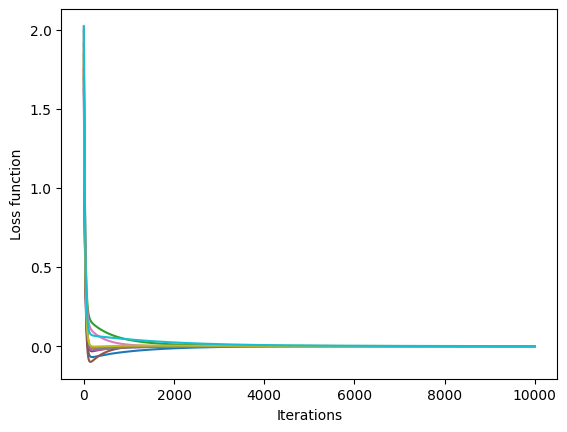

In [ ]:
# PLotting the loss values for every training iterations

loss_plot = [loss_hist[i][0] for i in range(len(loss_hist))]
plt.xlabel("Iterations")
plt.ylabel("Loss function")
plt.plot(loss_plot)
plt.show()

### 1.7. Plotting the histogram of loss

In [ ]:
def mse_losses(X, y, w, b):
    y_pred = (np.dot(X, w.T) + b).flatten()
    losses = (y_pred - y)**2
    return losses

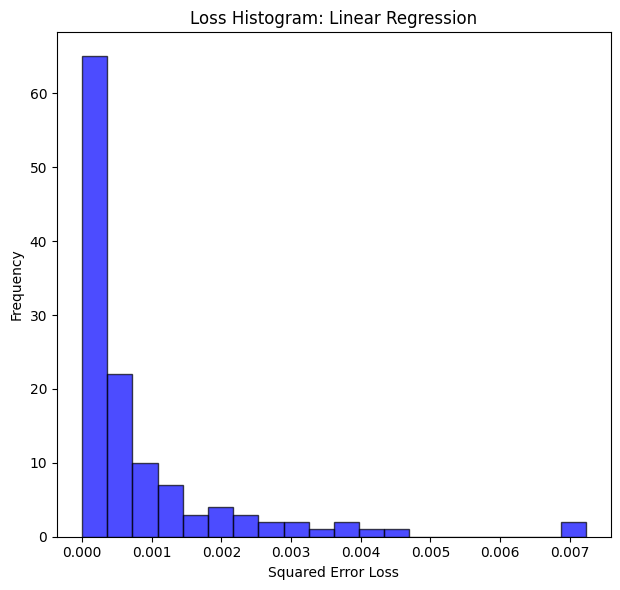

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Compute squared error loss for linear regression
loss_linear = mse_losses(X_test,y_test_scaled,w,b)

# Plot histograms
plt.figure(figsize=(12, 6))

# Linear regression loss histogram
plt.subplot(1, 2, 1)
plt.hist(loss_linear, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title('Loss Histogram: Linear Regression')
plt.xlabel('Squared Error Loss')
plt.ylabel('Frequency')


plt.tight_layout()
plt.show()


### 1.8 Experimenting with different values of the Hyperparemeters

Previously, we have took the learning rate as 0.001. Now, you may train the model again by taking learning rate as-


1.   0.01
2.   0.001


After the model is trained, you can compare the performance of the model with these chosen hyperparameters.